In [253]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import re
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from sklearn.cluster import KMeans
from scipy import stats

### Read in Data

In [3]:
df = pd.read_csv("/Users/gabrieltaylor/Python/STAT542/en.openfoodfacts.org.products.tsv", sep = "\t")

/Users/gabrieltaylor/.pyenv/versions/3.7.3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,36,37,38,39,48) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,3087,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,4559,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,16087,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,16094,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Plot Missing Values

In [5]:
miss_vals = pd.DataFrame(df.isna().mean()).reset_index()
miss_vals.columns = ["Columns", "MV Rate"]
miss_vals = miss_vals.sort_values("MV Rate")

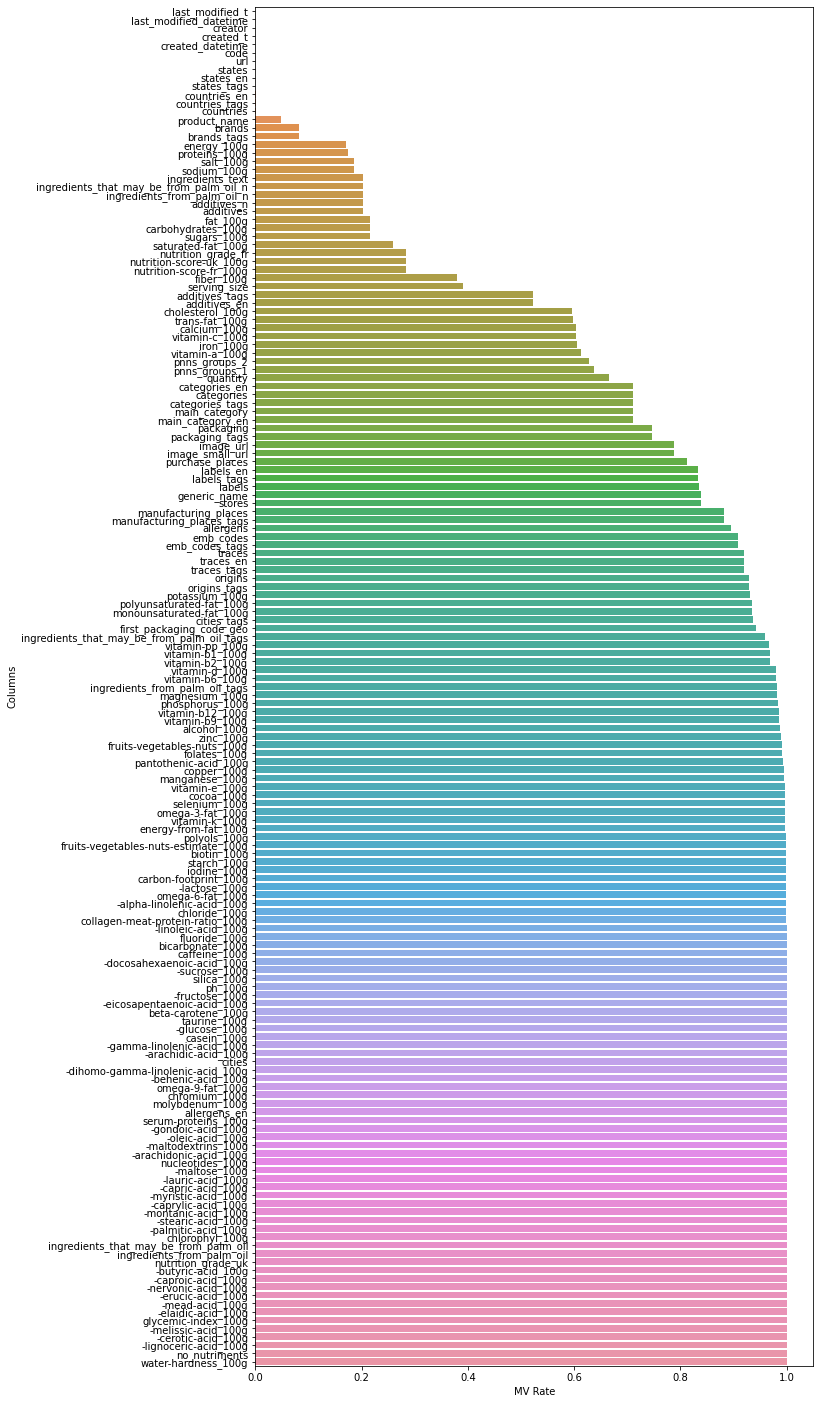

In [88]:
plt.figure(figsize = (10, 25))
sns.barplot("MV Rate", "Columns", data = miss_vals, orient = "h")

### Remove Columns above 30% Missing Values

In [7]:
keep_cols = miss_vals[miss_vals["MV Rate"] < 0.3]["Columns"]

In [8]:
df2 = df[keep_cols]

### Remove General Information 

In [9]:
rm_cols = [ 'last_modified_t',
            'last_modified_datetime',
             'creator',
             'created_t',
             'created_datetime',
             'code',
             'url',
             'states',
             'states_en',
             'states_tags',
             'countries_tags',
             'countries',
             'ingredients_that_may_be_from_palm_oil_n',
             'ingredients_from_palm_oil_n',
             'product_name', ### Perhaps Keep
             'brands', ### Perhaps Keep
             'brands_tags',
             'additives', ### contained in ingredients
             'additives_n',
             'nutrition-score-uk_100g', ### Related to target
             'nutrition_grade_fr', ### Related to target
             'salt_100g' ### Sodium will suffice
          ]

In [10]:
df3 = df2.drop(rm_cols, axis = 1)

## Check Missingness

In [11]:
pd.DataFrame(df3.isna().mean()).reset_index()

,index,0
0,countries_en,0.000772
1,energy_100g,0.170380
2,proteins_100g,0.173768
3,sodium_100g,0.186315
4,ingredients_text,0.202608
5,fat_100g,0.214956
6,carbohydrates_100g,0.215734
7,sugars_100g,0.215829
8,saturated-fat_100g,0.258980
9,nutrition-score-fr_100g,0.284167


### Remove All Missing Rows For Right Now

In [12]:
df4 = df3.dropna()

In [13]:
df4.shape[0] / df3.shape[0]

0.6426394627373767

## Document Term Matrix For Ingredients

Keep only latin letters

In [14]:
ingredients = ["Missing" if pd.isna(ing) else re.sub('[^A-Za-z]', ' ', ing) for ing in df4['ingredients_text']]

List of all words

In [15]:
all_words = [i for ing in ingredients for i in ing.split()]

List of stop words (will be improved later)

In [16]:
rm_words = ['de', 'contains', 's', 'et', 'of', 'en', 'less', 'p']

Keep only the most common words

In [17]:
most_common_words = Counter(all_words).most_common(100)
most_common_words = [word[0] for word in most_common_words if word[0] not in rm_words]

In [18]:
keep_ingredients = [" ".join([word for word in ing.split() if word in most_common_words]) for ing in ingredients ]

Form the document term matrix

In [19]:
vec = CountVectorizer()
X = vec.fit_transform(keep_ingredients)
dtm = pd.DataFrame(X.toarray(), columns = vec.get_feature_names())
dtm.to_csv("/Users/gabrieltaylor/Python/STAT542/dtm.csv")
dtm.head()

,acid,acide,amidon,and,ar,artificial,beurre,bl,butter,cacao,...,tournesol,vegetable,vinegar,vitamin,water,wheat,whey,whole,with,yeast
0,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,2,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,3,0,0,0,0


In [20]:
df5 = pd.concat([df4.reset_index(drop = True), dtm], axis = 1)

### Drop Ingredients Column

In [21]:
df6 = df5.drop('ingredients_text', axis = 1)
df6.head()

,countries_en,energy_100g,proteins_100g,sodium_100g,fat_100g,carbohydrates_100g,sugars_100g,saturated-fat_100g,nutrition-score-fr_100g,acid,...,tournesol,vegetable,vinegar,vitamin,water,wheat,whey,whole,with,yeast
0,United States,2243.0,3.57,0.000,28.57,64.29,14.29,28.57,14.0,0,...,0,1,0,0,0,0,0,0,0,0
1,United States,1941.0,17.86,0.250,17.86,60.71,17.86,0.00,0.0,0,...,0,0,0,0,1,2,0,0,0,0
2,United States,2540.0,17.86,0.482,57.14,17.86,3.57,5.36,12.0,0,...,0,0,0,0,0,0,0,0,0,0
3,United States,1833.0,14.06,0.055,18.75,57.81,15.62,4.69,7.0,0,...,0,0,0,1,0,0,0,0,0,0
4,United States,2230.0,16.67,0.633,36.67,36.67,3.33,5.00,12.0,0,...,0,0,0,0,2,3,0,0,0,0


# Summary Stats

In [22]:
df6.iloc[ : , 1:9].describe()

,energy_100g,proteins_100g,sodium_100g,fat_100g,carbohydrates_100g,sugars_100g,saturated-fat_100g,nutrition-score-fr_100g
count,228797.000000,228797.000000,228797.000000,228797.000000,228797.000000,228797.000000,228797.000000,228797.000000
mean,1171.881431,7.785698,0.640734,13.319653,32.531768,14.799492,4.880056,9.166230
std,765.953642,8.191208,53.205645,16.262195,28.313047,19.721820,7.407708,8.998898
min,0.000000,-3.570000,0.000000,0.000000,0.000000,-17.860000,0.000000,-15.000000
25%,448.000000,1.770000,0.039370,0.830000,6.670000,1.200000,0.000000,1.000000
50%,1176.000000,5.620000,0.250000,7.100000,22.670000,5.000000,1.790000,10.000000
75%,1707.000000,10.800000,0.536000,21.430000,58.180000,22.580000,7.060000,16.000000
max,14644.000000,305.000000,25320.000000,100.000000,165.000000,145.000000,100.000000,40.000000


### Center and Scale Nutrition Facts

In [23]:
df6.columns[1:8]

Index(['energy_100g', 'proteins_100g', 'sodium_100g', 'fat_100g',
       'carbohydrates_100g', 'sugars_100g', 'saturated-fat_100g'],
      dtype='object')

In [24]:
def scale(x):
    return (x - np.mean(x)) / np.std(x)

In [25]:
### Dont scale nutrition score
for col in df6.columns[1:7]:
    df6[col] = scale(np.array(df6[col]))

In [26]:
df6.iloc[ : , :8].describe()

,energy_100g,proteins_100g,sodium_100g,fat_100g,carbohydrates_100g,sugars_100g,saturated-fat_100g
count,2.287970e+05,2.287970e+05,2.287970e+05,2.287970e+05,2.287970e+05,2.287970e+05,228797.000000
mean,6.360186e-17,2.514261e-16,-2.562087e-18,1.773896e-16,1.341602e-16,-3.726672e-17,4.880056
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,7.407708
min,-1.529967e+00,-1.386331e+00,-1.204263e-02,-8.190580e-01,-1.149005e+00,-1.656012e+00,0.000000
25%,-9.450742e-01,-7.344107e-01,-1.130267e-02,-7.680193e-01,-9.134243e-01,-6.895673e-01,0.000000
50%,5.377058e-03,-2.643935e-01,-7.343869e-03,-3.824617e-01,-3.483125e-01,-4.968868e-01,1.790000
75%,6.986320e-01,3.679932e-01,-1.968488e-03,4.987251e-01,9.058823e-01,3.945136e-01,7.060000
max,1.758873e+01,3.628463e+01,4.758783e+02,5.330187e+00,4.678709e+00,6.601865e+00,100.000000


# Unsupervised Task

## Clustering Macronutrients by Nutrition Score

In [308]:
keep_cols = ['nutrition-score-fr_100g', 'carbohydrates_100g','proteins_100g', 'fat_100g', 'fiber_100g']
clust_df = df[keep_cols]
clust_df = clust_df.dropna()

In [309]:
### Remove outliers
clust_df = clust_df[(np.abs(stats.zscore(clust_df)) < 3).all(axis = 1)]

In [310]:
clust_df.describe()

,nutrition-score-fr_100g,carbohydrates_100g,proteins_100g,fat_100g,fiber_100g
count,191523.000000,191523.000000,191523.000000,191523.000000,191523.000000
mean,8.463594,34.750752,7.273655,11.900787,2.866883
std,8.994034,28.150525,6.861299,13.479425,5.511323
min,-15.000000,0.000000,-3.570000,0.000000,0.000000
25%,1.000000,8.300000,2.000000,0.770000,0.000000
50%,9.000000,27.000000,5.560000,6.500000,1.600000
75%,15.000000,60.470000,10.500000,20.000000,3.600000
max,35.000000,106.000000,31.910000,60.530000,990.000000


In [311]:
true_labs = list(map(lambda x: 1 if x > 8.0 else 0, clust_df['nutrition-score-fr_100g']))
clust_df['nutrition-score-fr_100g'] = true_labs

### Kmeans

In [312]:
X = np.array(clust_df.drop('nutrition-score-fr_100g', axis = 1))
kmeans = KMeans(n_clusters = 2, random_state = 69).fit(X)

In [313]:
np.mean(kmeans.labels_ != true_labs)

0.6699978592649447

### Macro Profile of Clusters

In [314]:
clust_df['clust'] = kmeans.labels_

In [315]:
clust_df.groupby('clust').mean()

,nutrition-score-fr_100g,carbohydrates_100g,proteins_100g,fat_100g,fiber_100g
clust,,,,,
0,0.699900,63.642692,7.184169,13.763348,4.264379
1,0.353418,12.125893,7.343731,10.442243,1.772524


## Clustering Macronutrient Profile by Food Category

In [297]:
keep_cols = ['categories_en', 'carbohydrates_100g', 'proteins_100g', 'fat_100g', 'fiber_100g']
clust_df = df[keep_cols]
clust_df = clust_df.dropna().reset_index(drop = True)
clust_df.shape

(45749, 5)

In [298]:
clust_df['categories'] = [re.sub(",", " ", s) for s in clust_df['categories_en']]
clust_df['categories'] = [s.split()[0] for s in clust_df['categories']]
clust_df['categories'].value_counts().head(20)

Plant-based    16735
Sugary          6391
Beverages       3194
Dairies         2438
Groceries       1917
Meals           1736
Fresh           1618
Salty           1485
Meats           1412
Frozen          1252
Canned           771
Desserts         743
Spreads          733
Seafood          558
Baby             455
Fats             445
Sandwiches       330
Breakfasts       247
Dried            212
Sweeteners       182
Name: categories, dtype: int64

### Meats vs. Plant-Based

In [299]:
m_pb = clust_df[clust_df['categories'].isin(['Plant-based', 'Meats', 'Dairies', 'Seafood'])].drop('categories_en', axis = 1)
m_pb['categories'] = ["Plant-based" if i == 'Plant-based' else 'Meats' for i in m_pb['categories']]

In [300]:
m_pb['categories'].value_counts()

Plant-based    16735
Meats           4408
Name: categories, dtype: int64

#### Sample Plant-based foods

In [301]:
pb_samp = m_pb[m_pb.categories == 'Plant-based'].sample(10000 - 4408)

In [302]:
m_pb_sampled = m_pb[m_pb.categories == 'Meats'].append(pb_samp).reset_index(drop = True)
m_pb_sampled.shape

(10000, 5)

### Kmeans

In [303]:
X = np.array(m_pb_sampled.drop('categories', axis = 1))
kmeans = KMeans(n_clusters = 2, random_state = 69).fit(X)

In [304]:
true_labs = list(map(lambda x: 1 if x == 'Meats' else 0, m_pb_sampled['categories']))

In [305]:
np.mean(kmeans.labels_ != true_labs)

0.6779

### Macro Profile of Clusters

In [306]:
m_pb_sampled['clust'] = kmeans.labels_

In [307]:
m_pb_sampled.groupby('clust').mean()

,carbohydrates_100g,proteins_100g,fat_100g,fiber_100g
clust,,,,
0,7.313022,9.032954,10.683894,1.369271
1,62.740490,8.901493,5.791871,5.261882


# Supervised Task